In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from lime.lime_tabular import LimeTabularExplainer

pd.set_option('display.max_columns', None)

In [2]:
# Class to help select categorical vs. continuous data as part of the pipeline (see below)
class DataSelector(BaseEstimator, TransformerMixin):
    '''Select columns of numpy arrays based on attribute_indices.'''

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [3]:
df = pd.read_csv('data.csv')


In [4]:
diag_map = {'M':1, 'B':0}
df['diagnosis'] = df['diagnosis'].map(diag_map)

In [5]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [6]:
labels = df.diagnosis

In [7]:
# Define categorical names and indices
categorical_features = list(df.columns[5:])
categorical_idx = list(range(5, len(df.columns)))
continuous_features = list(df.columns[0:5])
continuous_idx = list(range(0,5))

X = df.values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(X[:, idx])
    categorical_names[idx] = le.classes_


# To suppress a warning later (not strictly necessary)
X = X.astype(float)

# Train test split
train, test, labels_train, labels_test = train_test_split(
    X, labels, train_size=0.70, random_state=42
)


/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
# Preprocessing pipeline
#      
# LIME needs a function that takes raw inputs and returns a prediction (see below).     
# We use sklearn's pipeline to handle preprocessing, it simplifies the interaction with LIME (see below). 
# There are several ways to build this pipeline. For demo purposes, we here show the verbose option (and we
# avoid scaling one-hot encoded features).

continuous_pipeline = Pipeline([
    ('selector', DataSelector(continuous_idx)),
    ('scaler', StandardScaler()),
    ])

categorical_pipeline = Pipeline([
    ('selector', DataSelector(categorical_idx)),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("continuous_pipeline", continuous_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ])

# There are less verbose alternatives, especially if we scale one-hot encoded features,
# an accepted practice in the machine learning community:
#
#     preprocessing_pipeline = Pipeline([
#        ('onehotencoder', OneHotEncoder(categorical_features=categorical_idx, sparse=False)),
#        ('scaler', StandardScaler())
#     ])
#
# Finally, instead of the low-level Pipeline constructor, we can use sklearn's makepipeline:
#
#     preprocessing_pipeline = make_pipeline(
#         OneHotEncoder(categorical_features=categorical_idx, sparse=False),
#         StandardScaler()
#     )

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import time

# Set up the model and GridSearch for random forest hyperparameter tuning
param_grid = [{'n_estimators': [16, 20, 24],
               'max_features': [4, 8, 12, 16],
               'min_samples_split': [8, 12, 16],
               'max_depth': [15, 20, 25]}]

rf = RandomForestClassifier(class_weight='balanced')
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')

# Extend the preprocessing pipeline to include random forest and grid search
pipeline = make_pipeline(preprocessing_pipeline, grid_search)

# Fit the model and tune the hyperparameters
pipeline.fit(train, labels_train)

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous_pipeline', Pipeline(memory=None,
     steps=[('selector', DataSelector(attribute_indices=[0, 1, 2, 3, 4])), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('categorical_pipeline', Pipeline(..._jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0))])

In [10]:
# Hyperparameters found by GridSearchCV
print(pipeline.named_steps['gridsearchcv'].best_params_)

{'max_features': 16, 'min_samples_split': 8, 'n_estimators': 16, 'max_depth': 25}


In [11]:
# Get feature importances of random forest model ("global interpretability")
best_estimator = pipeline.named_steps['gridsearchcv'].best_estimator_

importances = best_estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_names = df.columns
for f in range(df.shape[1]):
    print("%2d. feature %s (%f)" %
          (f + 1, feature_names[f], importances[indices[f]]))

Feature ranking:
 1. feature id (0.044176)
 2. feature diagnosis (0.009310)
 3. feature radius_mean (0.009108)
 4. feature texture_mean (0.007625)
 5. feature perimeter_mean (0.007015)
 6. feature area_mean (0.006592)
 7. feature smoothness_mean (0.006159)
 8. feature compactness_mean (0.005944)
 9. feature concavity_mean (0.005941)
10. feature concave points_mean (0.005268)
11. feature symmetry_mean (0.005163)
12. feature fractal_dimension_mean (0.005009)
13. feature radius_se (0.004964)
14. feature texture_se (0.004903)
15. feature perimeter_se (0.004845)
16. feature area_se (0.004781)
17. feature smoothness_se (0.004759)
18. feature compactness_se (0.004546)
19. feature concavity_se (0.004542)
20. feature concave points_se (0.004330)
21. feature symmetry_se (0.004315)
22. feature fractal_dimension_se (0.004312)
23. feature radius_worst (0.004218)
24. feature texture_worst (0.004203)
25. feature perimeter_worst (0.004163)
26. feature area_worst (0.004095)
27. feature smoothness_worst

In [12]:
# Use LIME to explain individual predictions, initialize explainer object
explainer = LimeTabularExplainer(
    train,
    class_names=['1', '0'],
    feature_names=list(df.columns),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

('Getting Cancer prob.:', 0.40835490755546117)


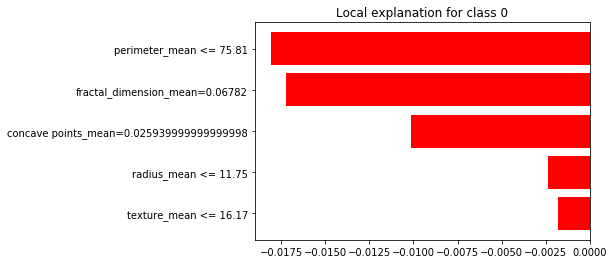

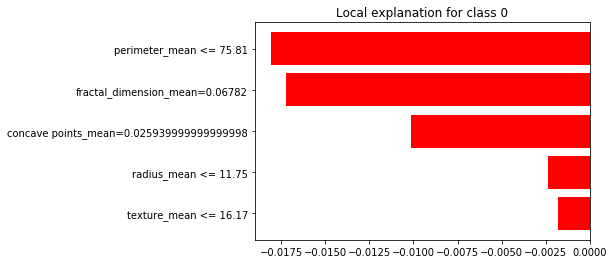

In [21]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction 
# of the trained model now comes in conveniently.
# Explain another prediction ("local interpretability"): 
example = 4
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
print('Getting Cancer prob.:', exp.predict_proba[1])
exp.as_pyplot_figure()

('Getting Cancer prob.:', 0.46446386923876565)


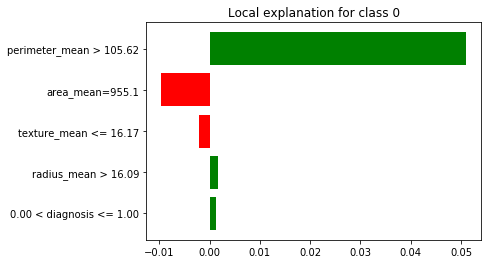

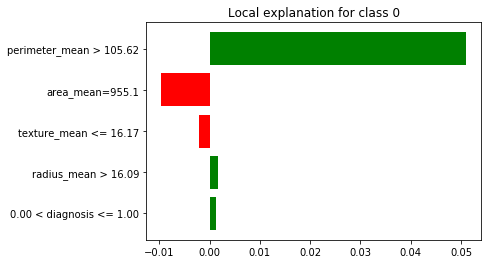

In [23]:
# Explain another prediction ("local interpretability"): 
example = 7
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
print('Getting Cancer prob.:', exp.predict_proba[1])
exp.as_pyplot_figure()

('Getting Cancer prob.:', 0.46446386923876565)


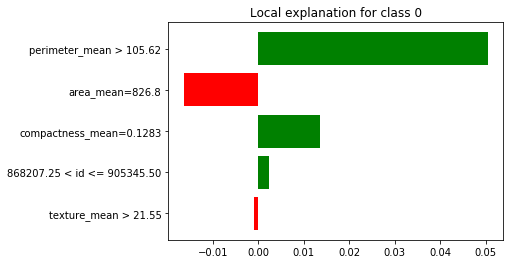

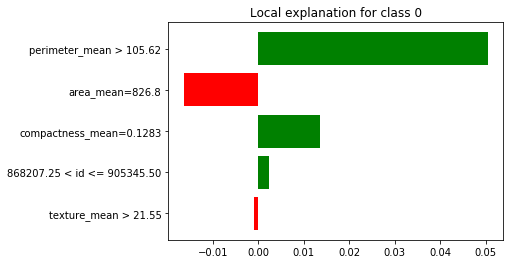

In [15]:
# Explain another prediction ("local interpretability"): 
example = 13
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
print('Getting Cancer prob.:', exp.predict_proba[1])
exp.as_pyplot_figure()

('Getting Cancer prob.:', 0.46446386923876565)


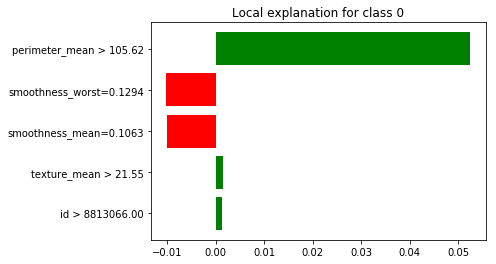

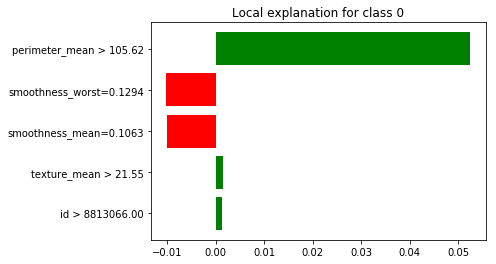

In [18]:
# Explain another prediction ("local interpretability"): 
example = 6
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
print('Getting Cancer prob.:', exp.predict_proba[1])
exp.as_pyplot_figure()

('Getting Cancer prob.:', 0.4817957039118465)


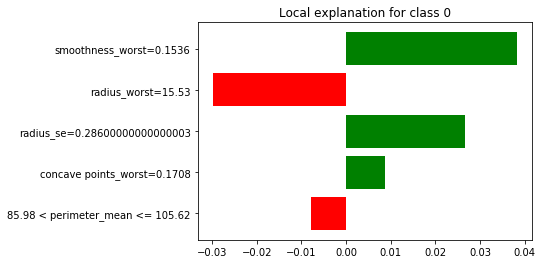

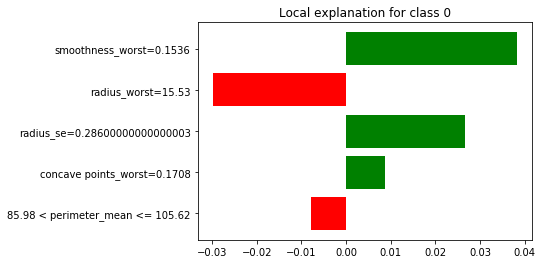

In [20]:
# Explain another prediction ("local interpretability"): 
example = 8
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
print('Getting Cancer prob.:', exp.predict_proba[1])
exp.as_pyplot_figure()